In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('cs_dataset.csv')


## Performing ARIMA on Immigrant Population Percentage Data

<Axes: title={'center': 'US Immigrant Population Percentage'}>

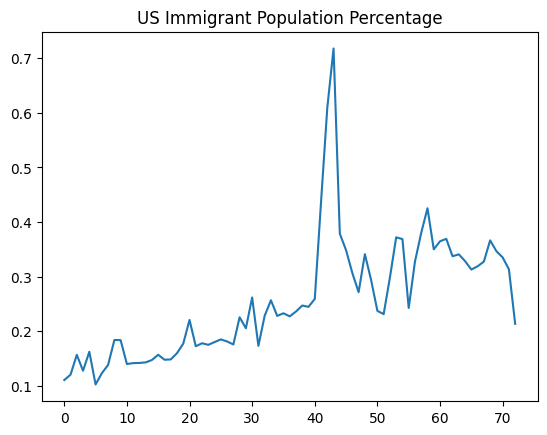

In [2]:
df1 = df["migrant_pop_percentage"]
df1.plot(title="US Immigrant Population Percentage")



<Axes: title={'center': 'Log of US Immigrant Population Percentage'}>

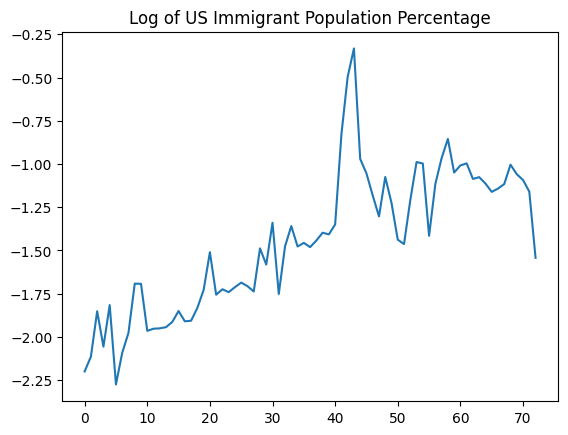

In [3]:

df1 = np.log(df1)
df1.plot(title="Log of US Immigrant Population Percentage")

## Check for Stationarity

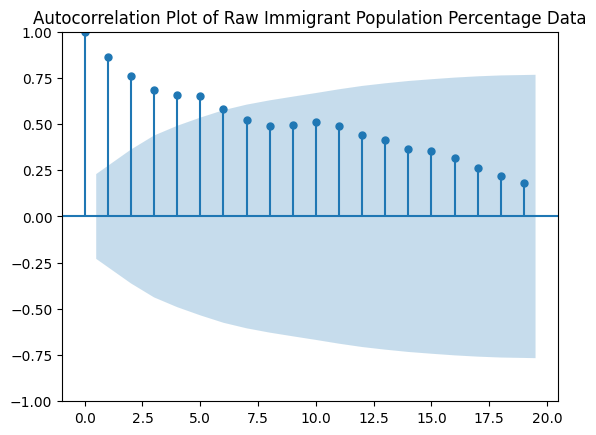

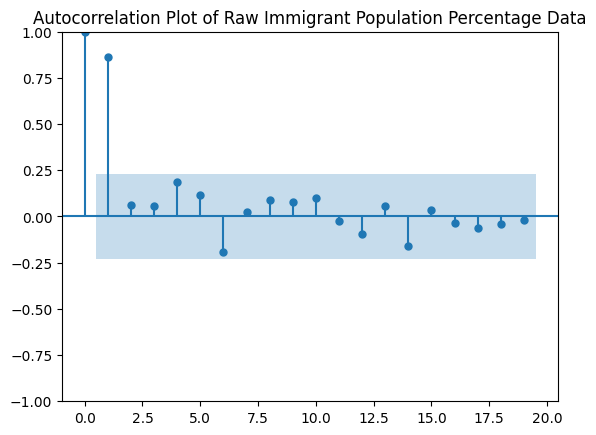

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df1, title="Autocorrelation Plot of Raw Immigrant Population Percentage Data")
pacf_original = plot_pacf(df1, title="Autocorrelation Plot of Raw Immigrant Population Percentage Data")

In [5]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df1)
print(f'p-value: {adf_test[1]}')

p-value: 0.11337830583129122


The ACF has a positive decline, and the PACF has a spike at the beginning, so these indicate the data are not stationary. Additionally, the p-value is way too high. So let's transform da time series to stationary by differencing!

## Stationarity: Differencing

<Axes: title={'center': 'Immigrant Population Percentage Differenced Once'}>

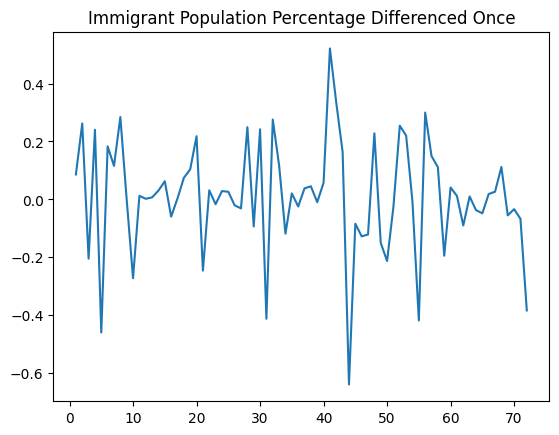

In [6]:
df1_diff = df1.diff().dropna()
df1_diff.plot(title="Immigrant Population Percentage Differenced Once")

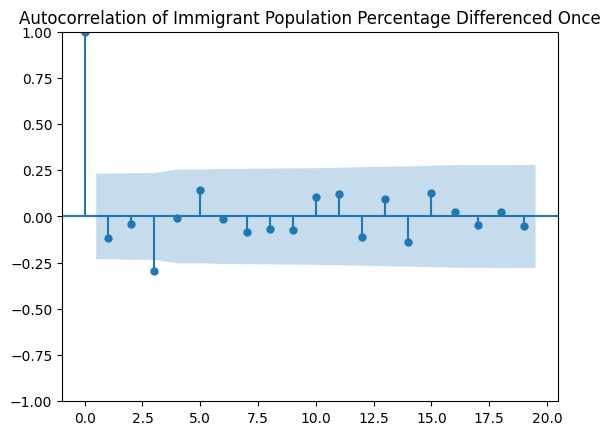

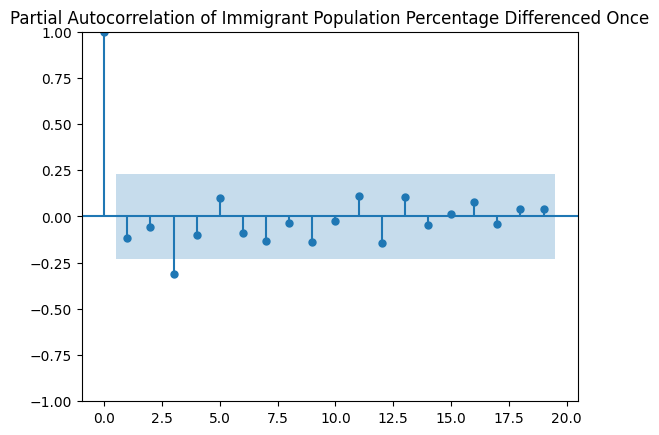

In [7]:
acf_diff = plot_acf(df1_diff, title="Autocorrelation of Immigrant Population Percentage Differenced Once")
pacf_diff = plot_pacf(df1_diff, title="Partial Autocorrelation of Immigrant Population Percentage Differenced Once")

In [8]:
adf_test = adfuller(df1_diff)
print(f'p-value: {adf_test[1]}')

p-value: 1.784415936025569e-09


## Determining ARIMA models parameters p,q

In [9]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df1, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     migrant_pop_percentage   No. Observations:                   73
Model:                     ARIMA(1, 1, 0)   Log Likelihood                  15.925
Date:                    Sun, 08 Dec 2024   AIC                            -27.850
Time:                            22:05:49   BIC                            -23.296
Sample:                                 0   HQIC                           -26.037
                                     - 73                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1202      0.103     -1.166      0.244      -0.322       0.082
sigma2         0.0376      0.005      7.439      0.000       0.028       0.048
Ljung-Box (L1) (Q): 

## Residuals

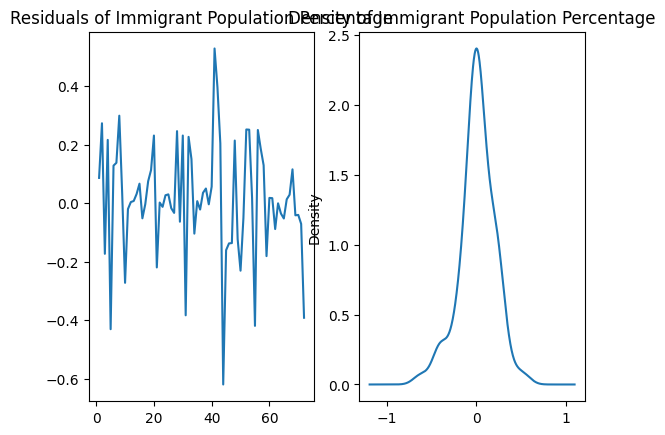

In [10]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals of Immigrant Population Percentage", ax=ax[0])
residuals.plot(title="Density of Immigrant Population Percentage", kind="kde", ax=ax[1])
plt.show()

### You want to modify your ARIMA parameters until the residual plot is stationary, and the residual density plot has a normal-ish curve that is centered at 0

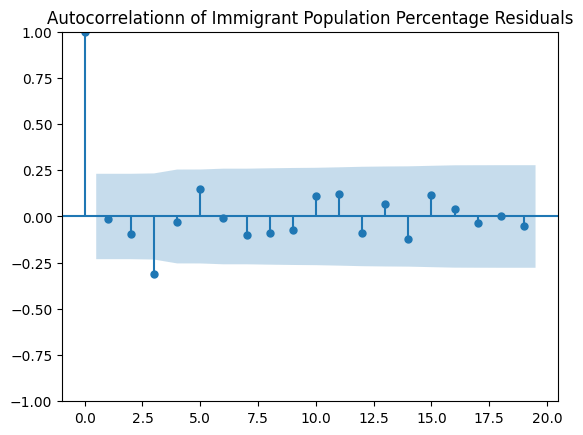

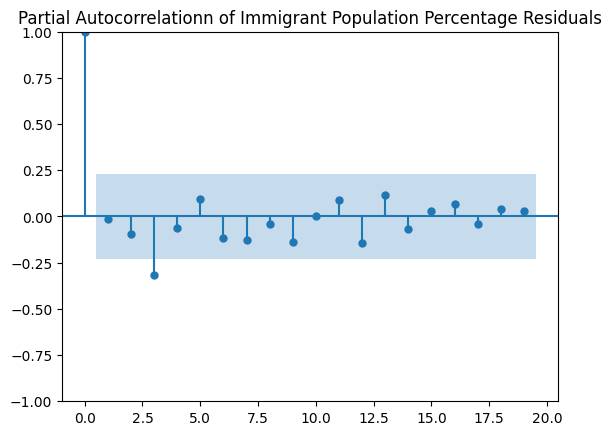

In [11]:
# acf and pacf of residuals
acf_residual = plot_acf(residuals, title="Autocorrelationn of Immigrant Population Percentage Residuals")
pacf_residual = plot_pacf(residuals, title="Partial Autocorrelationn of Immigrant Population Percentage Residuals")

## Performing Cross Correlation

In [12]:
from statsmodels.tsa.stattools import ccf    

'''
residualsX: run arima on data X and obtain residuals
stationaryY: data Y (not with arima), but needs to be stationary
'''
def cross_corr(residualsX, stationaryY, lags=0):
	# explaining x with y
    print("\nCross-Correlation for lags up to {}: ".format(lags))
    for lag in range(-lags, lags+1):  # Includes negative lags
        cross_corr = ccf(residualsX, stationaryY, adjusted=False)[lag + lags]
        print(f"Lag = {lag}: {cross_corr}")


### Call the cross_corr function with the first parameter as the independent variable, and the second as the dependent